[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
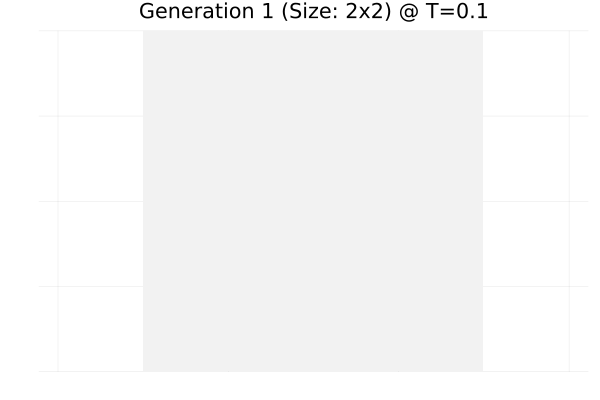

[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
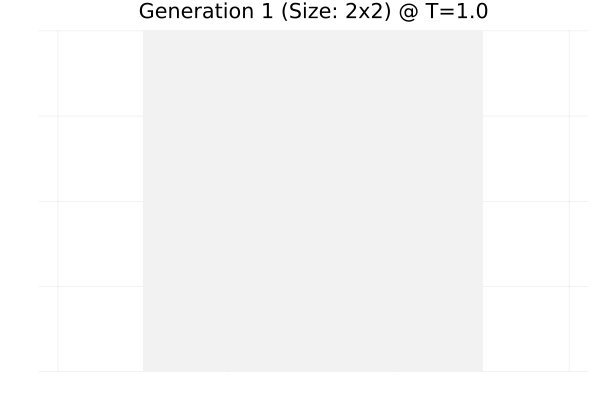

[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
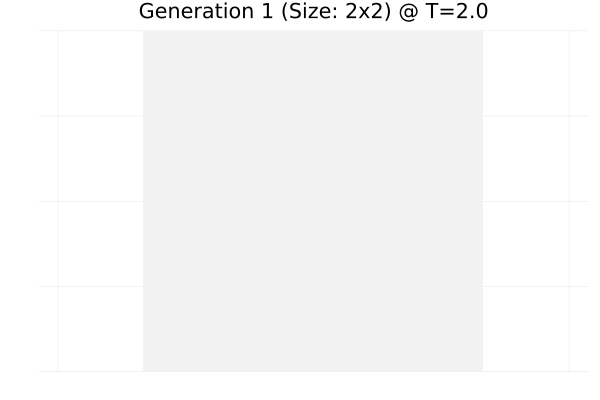

[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
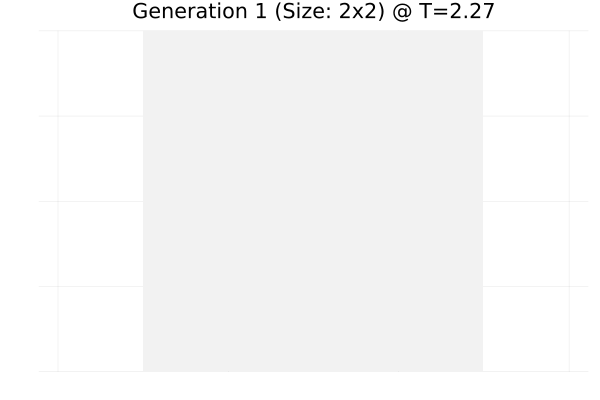

[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
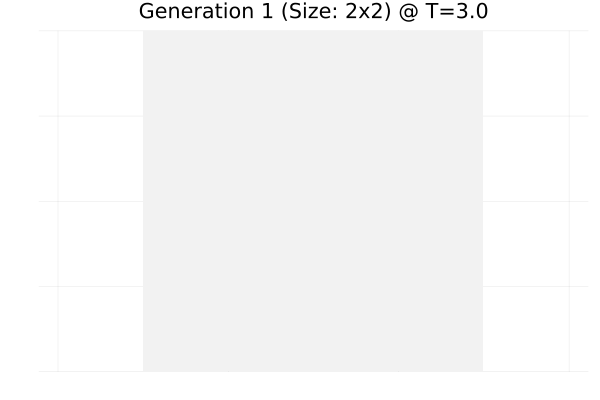

[ Info: Saved animation to /home/souta/work/QuasiCrystal.jl/dev/tmp.gif


Plots.AnimatedGif("/home/souta/work/QuasiCrystal.jl/dev/tmp.gif")
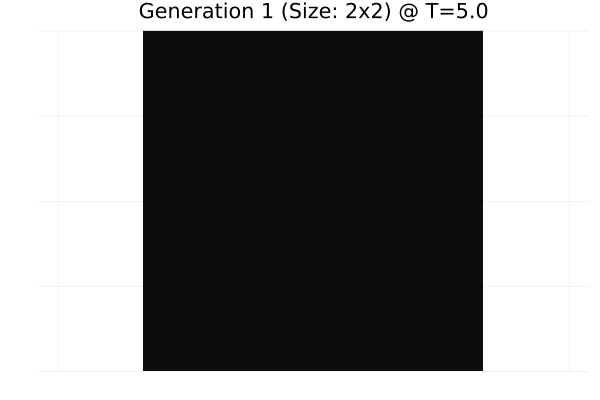

In [ ]:
using LinearAlgebra, Statistics, StatsBase, Plots

function sample_block_2d(parent::Int, T::Float64, J::Float64=1.0, h_bias::Float64=1.0)
    β = 1.0 / T

    # 2x2ブロックの全16状態を生成 (s1, s2, s3, s4)
    # s1 s2
    # s3 s4
    states = [((i >> 3) & 1, (i >> 2) & 1, (i >> 1) & 1, i & 1) for i in 0:15]
    # 0 -> -1, 1 -> +1 に変換
    states_spin = [map(x -> x == 1 ? 1 : -1, s) for s in states]

    weights = Float64[]

    for s in states_spin
        s1, s2, s3, s4 = s
        # ブロック内のエネルギー (Nearest Neighbor on square)
        # s1-s2, s2-s4, s4-s3, s3-s1 の4ボンドと仮定
        E_internal = -J * (s1 * s2 + s2 * s4 + s4 * s3 + s3 * s1)

        # 親スピンによるバイアス（外部磁場的に作用）
        E_bias = -h_bias * parent * (s1 + s2 + s3 + s4)

        push!(weights, exp(-β * (E_internal + E_bias)))
    end

    chosen_idx = sample(1:16, Weights(weights))
    s1, s2, s3, s4 = states_spin[chosen_idx]

    return [s1 s2; s3 s4]
end

function grow_ising_2d(lattice::Matrix{Int}, T::Float64)
    Lx, Ly = size(lattice)
    new_Lx, new_Ly = 2 * Lx, 2 * Ly
    new_lattice = zeros(Int, new_Lx, new_Ly)

    for j in 1:Ly, i in 1:Lx
        parent = lattice[i, j]
        block = sample_block_2d(parent, T)

        # 新しい格子にブロックを配置
        # インデックス計算: (i,j) -> (2i-1:2i, 2j-1:2j)
        new_lattice[2i-1:2i, 2j-1:2j] = block
    end

    return new_lattice
end

# --- 実行と可視化 ---

# パラメータ設定
generations = 12      # 成長回数 (2^7 = 128x128)
T_crit_approx = 2.27 # Onsager解 (2D IsingのTc) 付近
T = T_crit_approx * 0.8 # 低温相でドメインを見やすくする
# T = T_crit_approx * 1.5 # 高温相
T_list = [0.1, 1.0, 2.0, 2.27, 3.0, 5.0]
# 初期状態: 1つのアップスピン (+1)

# 成長ループ
for T in T_list
    lattice = ones(Int, 1, 1)
    anim = @animate for g in 1:generations
        global lattice
        lattice = grow_ising_2d(lattice, T)

        heatmap(lattice,
            aspect_ratio=1,
            c=:grays,
            clims=(-1, 1),
            legend=false,
            axis=false,
            title="Generation $g (Size: $(size(lattice,1))x$(size(lattice,1))) @ T=$T"
        )
    end
    display(gif(anim, fps=6))
end


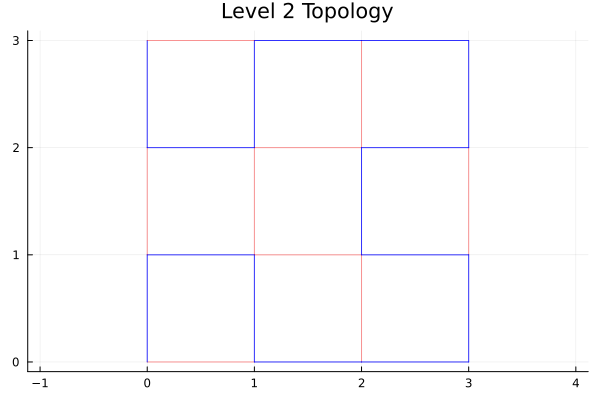

In [5]:
using StaticArrays, LinearAlgebra, Plots

abstract type AbstractTiles{N,T} end

# S2 (Bond情報) を保持するために構造体を拡張
struct TopologyTile{N,T} <: AbstractTiles{N,T}
    level::Int
    str::String
    positions::Vector{SVector{N,T}}
    # S2: (site_i, site_j) のペアを保存。
    # 物理的な隣接関係 (Nearest Neighbor)
    bonds::Set{Pair{Int,Int}}
    angle::T
    rules::Dict{Char,String}
end

# 初期化関数
function initialize_topology(::Type{TopologyTile{N,T}}, axiom::String, rules::Dict{Char,String}; angle=π / 2) where {N,T}
    return TopologyTile{N,T}(0, axiom, [SVector{N,T}(zeros(T, N)...)], Set{Pair{Int,Int}}(), T(angle), rules)
end

# S1 (文字列) の成長処理
function grow_tile(tile::TopologyTile{N,T}) where {N,T}
    new_str = sprint() do io
        for c in tile.str
            if haskey(tile.rules, c)
                print(io, tile.rules[c])
            else
                print(io, c)
            end
        end
    end
    return TopologyTile{N,T}(tile.level + 1, new_str, tile.positions, Set{Pair{Int,Int}}(), tile.angle, tile.rules)
end

# S1から座標を計算し、同時にS2 (Bond) を抽出する
function compute_topology!(tile::TopologyTile{2,T}) where T
    pos = SVector{2,T}(0.0, 0.0)
    direction = SVector{2,T}(0.0, 1.0)

    # 座標リストと、座標からインデックスを引くための逆引き辞書
    positions = SVector{2,T}[]
    push!(positions, pos)
    coord_to_idx = Dict{SVector{2,T},Int}(pos => 1)

    # 文字列走査 (S1 -> S2への翻訳)
    current_idx = 1
    for cmd in tile.str
        if cmd == 'F'
            pos = SVector{2,T}(round.(pos + direction, digits=5)) # 浮動小数点の誤差回避
            push!(positions, pos)
            current_idx += 1
            coord_to_idx[pos] = current_idx

            # ここでS2 (Bond) を探索。
            # 2次元格子における4近傍 (Square Lattice) をチェック
            for offset in [SVector(1.0, 0.0), SVector(-1.0, 0.0), SVector(0.0, 1.0), SVector(0.0, -1.0)]
                neighbor_pos = SVector{2,T}(round.(pos + offset, digits=5))
                if haskey(coord_to_idx, neighbor_pos)
                    neighbor_idx = coord_to_idx[neighbor_pos]
                    if neighbor_idx != current_idx
                        # 小さいインデックスを前にして重複を防ぐ
                        push!(tile.bonds, min(current_idx, neighbor_idx) => max(current_idx, neighbor_idx))
                    end
                end
            end
        elseif cmd == '+'
            θ = tile.angle
            rot = @SMatrix [cos(θ) -sin(θ); sin(θ) cos(θ)]
            direction = rot * direction
        elseif cmd == '-'
            θ = -tile.angle
            rot = @SMatrix [cos(θ) -sin(θ); sin(θ) cos(θ)]
            direction = rot * direction
        end
    end

    # 構造体のフィールドを更新（イミュータブルなので再生成）
    return TopologyTile{2,T}(tile.level, tile.str, positions, tile.bonds, tile.angle, tile.rules)
end

# 可視化：パス（青）と追加されたボンド（赤）を描画
function plot_topology(tile::TopologyTile)
    mat = reduce(hcat, tile.positions)
    p = plot(aspect_ratio=1, legend=false, title="Level $(tile.level) Topology")

    # 全てのBondを描画 (S2の情報)
    for bond in tile.bonds
        p1 = tile.positions[bond.first]
        p2 = tile.positions[bond.second]
        # パス上の結合（隣接インデックス）は青、飛び越し結合は赤
        c = abs(bond.first - bond.second) == 1 ? :blue : :red
        alpha = c == :blue ? 0.8 : 0.4
        plot!(p, [p1[1], p2[1]], [p1[2], p2[2]], lw=1, color=c, alpha=alpha)
    end
    return p
end

# 実行
rules = Dict('A' => "-BF+AFA+FB-", 'B' => "+AF-BFB-FA+")
tile = initialize_topology(TopologyTile{2,Float64}, "A", rules)

for _ in 1:2
    tile = grow_tile(tile)
end
tile = compute_topology!(tile)
plot_topology(tile)
